In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
## Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
## create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
## reflect an existing database into a new model
## reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
## View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
## Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Run inspector to determine measurement table column names
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Run inspector to determine station table column names
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

The most recent date is : 2017-08-23


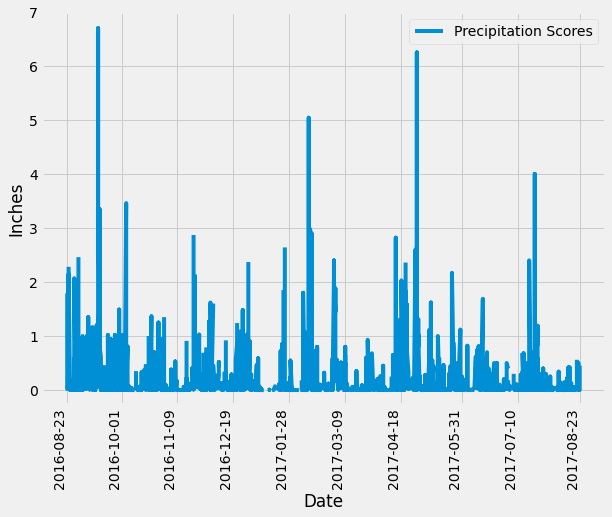

In [96]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results. 
## Starting from the most recent data point in the database. 

## Query for most recent date in database:
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date is : {recent_date[0]}")

#______________________________________________________________________________________________

## Calculate the date one year from the last date in data set.
query_date_start = dt.date(2017, 8, 23)
query_date = query_date_start - dt.timedelta(days=365)

#______________________________________________________________________________________________

## Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).\
filter(Measurement.date <= query_date_start).all()

#______________________________________________________________________________________________

## Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(year_data, columns = ["Date", "Precipitation Scores"])

# Replace None values with zero
prcp_df.dropna(how="any")

# Set index to Date
prcp_df.set_index('Date', inplace=True)

#______________________________________________________________________________________________

## Sort the dataframe by date
prcp_df.index = pd.DatetimeIndex(data=prcp_df.index)
prcp_df.sort_index(axis=0, inplace=True)

#______________________________________________________________________________________________

## Use Pandas Plotting with Matplotlib to plot the data

unique_index = prcp_df.index.unique()
intervals = [query_date]
x = 0
no_days = [39, 39, 40, 40, 40, 40, 43, 40, 44]
date_interval = query_date

for item in range(len(no_days)):
    date_interval = date_interval+dt.timedelta(days=no_days[x])
    intervals.append(date_interval)
    x += 1

maxlim = round((prcp_df["Precipitation Scores"].max()),0)

prcp_df.plot(figsize=(9,8), rot=90, xticks=intervals, ylim=(-.25, maxlim))
plt.ylabel("Inches")
plt.show()

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation Scores
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [97]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [98]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

station_df = pd.DataFrame(stations, columns=('Station','Station Activity Count'))
station_df

,Station,Station Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [99]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
sel = [Measurement.station, 
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]

active_station_temp = session.query(*sel).\
filter(Measurement.station == station_df["Station"][0]).all()

# Convert ast results to list:
ast = list(*active_station_temp)

# Print results
print(f"The minimum temperature for station {ast[0]} is {ast[1]}.")
print(f"The maximum temperature for station {ast[0]} is {ast[2]}.")
print(f"The average temperature for station {ast[0]} is {ast[3]}.")


The minimum temperature for station USC00519281 is 54.0.
The maximum temperature for station USC00519281 is 85.0.
The average temperature for station USC00519281 is 71.66378066378067.


Text(0, 0.5, 'Frequency')

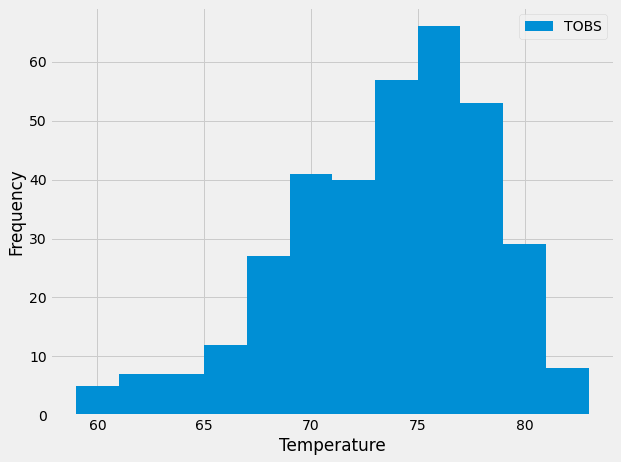

In [100]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_data_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= query_date).\
filter(Measurement.date <= query_date_start).filter(Measurement.station == ast[0]).all()

tobs_df = pd.DataFrame(year_data_tobs, columns=("Station", "TOBS"))


tobs_df.plot.hist(figsize=(9,7), bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close session

In [101]:
# Close Session
session.close()